### DSE-230 Final Project
## Diabetes Risk Prediction from Personal Health Indicators
***
#### Chunxia Tong  
#### Camm Perera
#### Sergey Gurvich

***
## Table of Contents:

* [1. Project Description and Setup](#project_description)
    * [1.1 Problem Description](#problem_description)
    * [1.2 Success Criteria](#success_criteria)
    * [1.3 Links](#links)
    * [1.4 Project Setup](#setup)
* [2. EDA](#eda)
    * [2.1 Dataset Dimensions and Schema](#eda)
    * [2.2 Missing Values](#missing_values_eda)
    * [2.3 Summary Statistics](#summary_statistics)
    * [2.4 Visualizations](#visualizations)
* [3. Data Preparation](#data_preparation)
    * [3.1 Features Removing](#data_preparation)
    * [3.2 Dataset Cleaning](#data_preparation)
    * [3.3 Feature Selection](#feature_selection)
    * [3.4 Feature Transformation](#feature_transformation)
* [4. Modeling](#modeling)
    * [4.1 Logistic Regression](#log_reg)
    * [4.2 Linear SVM](#lsvm)
    * [4.3 Decision Tree](#dtree)
    * [4.4 Gradient Boosted Tree Classifier](#gbtc)
    * [4.5 Random Forest Classifier](#rfc)
* [5. Results Evaluation](#evaluation)
    * [5.1 Selection of the Best Model](#evaluation)
    * [5.2 ROC Curves for Train and Test Data](#roc)
* [6. Stop Spark Session](#stop)
***

## 1. Project Description and Setup <a class="anchor" id="project_description"></a>

### 1.1 Problem Description <a class="anchor" id="problem_description"></a>
**Background:** 37.3 million US adults have diabetes, and 1 in 5 of them don’t know they have it. Diabetes is the seventh leading cause of death in the United States.  
**Dataset:** the Behavioral Risk Factor Surveillance System (BRFSS) is the nation’s premier system of health-related telephone surveys that collect state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services.  
**Applications:** healthcare and/or insurance industries.  
**Problem:** based on personal health indicators, predict if a person is at risk of developing the diabetes disease.  

### 1.2 Success Criteria <a class="anchor" id="success_criteria"></a>
Build a binary classification model that can make a prediction with 85% accuracy rate.

### 1.3 Links <a class="anchor" id="links"></a>
Project files in GIT: https://github.com/spring-camm-sergey/dse230  
Original dataset files and description: https://www.cdc.gov/brfss/annual_data/annual_2020.html


### 1.4 Project Setup <a class="anchor" id="setup"></a>
Please read Readme file located in https://github.com/spring-camm-sergey/dse230#readme

_Note: for running locally, please place the CSV files into HDFS. Example:_
```
hadoop fs -copyFromLocal work/project/BRFSS_2020_main_dataset.csv /;
hadoop fs -copyFromLocal work/project/Behavioral_Risk_Factor_Surveillance_System__BRFSS__Historical_Questions.csv /;
hadoop fs -copyFromLocal work/project/BRFSS_feature_codes_map.csv /;
```

#### 1.4.1 Imports

In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt
import pyspark
import numpy as np  # for histogram plot
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, abs
from pyspark.sql.types import FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC, LogisticRegression, DecisionTreeClassifier, GBTClassifier, RandomForestClassifier
from pyspark.ml.feature import StandardScaler, Normalizer, OneHotEncoder, VectorAssembler, StringIndexer, VectorIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

#### 1.4.2 Start Spark Session <a class="anchor" id="start_spark_session"></a>

In [2]:
conf = pyspark.SparkConf().setAll([('spark.master', 'local[*]'),
                                   ('spark.app.name', 'Basic Setup'),
                                    ('spark.memory.offHeap.enabled', True),
                                    ('spark.memory.offHeap.size','8g'),
                                    ('spark.executor.memory', '16g'), 
                                    ('spark.driver.memory','16g')
                                  ]
                                  )
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark.sparkContext.setLogLevel('OFF')
spark.version

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-29 18:59:10,066 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


'3.2.1'

#### 1.4.3 Read Data <a class="anchor" id="read_data"></a>

In [3]:
# main dataset
orig_df = spark.read.option("header", True).csv('hdfs:///BRFSS_2020_main_dataset.csv', inferSchema=True)

# csv of questionaire with possible answers
questions_df = spark.read.option("header", True).csv('hdfs:///Behavioral_Risk_Factor_Surveillance_System__BRFSS__Historical_Questions.csv', inferSchema=True)

# mapping of labels to actual questions
labels_map = spark.read.option("header", True).csv('hdfs:///BRFSS_feature_codes_map.csv', inferSchema=True)

## 2. EDA <a class="anchor" id="eda"></a>

### 2.1 Dataset Dimensions and Schema

In [4]:
orig_sdf  = orig_df
print(f"Number of samples: {orig_sdf.count()}")
print(f"Number of features: {len(orig_sdf.columns)}")

Number of samples: 401958
Number of features: 279


In [5]:
orig_sdf.printSchema()

root
 |-- _STATE: integer (nullable = true)
 |-- FMONTH: integer (nullable = true)
 |-- IDATE: integer (nullable = true)
 |-- IMONTH: integer (nullable = true)
 |-- IDAY: integer (nullable = true)
 |-- IYEAR: integer (nullable = true)
 |-- DISPCODE: integer (nullable = true)
 |-- SEQNO: integer (nullable = true)
 |-- _PSU: integer (nullable = true)
 |-- CTELENM1: integer (nullable = true)
 |-- PVTRESD1: integer (nullable = true)
 |-- COLGHOUS: integer (nullable = true)
 |-- STATERE1: integer (nullable = true)
 |-- CELPHONE: integer (nullable = true)
 |-- LADULT1: integer (nullable = true)
 |-- COLGSEX: integer (nullable = true)
 |-- NUMADULT: integer (nullable = true)
 |-- LANDSEX: integer (nullable = true)
 |-- NUMMEN: integer (nullable = true)
 |-- NUMWOMEN: integer (nullable = true)
 |-- RESPSLCT: integer (nullable = true)
 |-- SAFETIME: integer (nullable = true)
 |-- CTELNUM1: integer (nullable = true)
 |-- CELLFON5: integer (nullable = true)
 |-- CADULT1: integer (nullable = true)

### 2.2 Missing Values <a class="anchor" id="missing_values_eda"></a>

##### To preserve non-sparse samples, we removed columns that do not meet the threshhold: they must have at least 300k NOT NULLs:

In [6]:
# Note: this code was taken and modified per our needs from:
# https://stackoverflow.com/questions/51322445/how-to-drop-all-columns-with-null-values-in-a-pyspark-dataframe

def drop_null_columns(sdf, threshold=0):
    """
    Drops all columns which contain null values. 
    Leave columns, where count(not nulls) > threshhold.
    Note: Simulates pandas.DataFrame.dropna(axis=1, thresh=300000)
    
    :param Dataframe sdf: PySpark DataFrame to work with
    :param int threshold: min numbers of not nulls in column in order not to drop it
    :return: cleaned PySpark dataFrame
    """
    null_counts = sdf.select([count(when(
        col(c).isNull() | 
        col(c).contains('None') | 
        col(c).contains('NULL') | 
        col(c).contains('NA') | 
        (col(c)=='') | 
        (col(c)==99) | 
        isnan(c), 
        c)).alias(c) for c in sdf.columns]).collect()[0].asDict()
    
    to_drop = [k for k, v in null_counts.items() if v > sdf.count()-threshold]
    sdf = sdf.drop(*to_drop)
    return sdf



data_sdf = drop_null_columns(orig_sdf, threshold=300000)


print(f'Original number of samples: {orig_sdf.count()}, , number of columns: {len(orig_sdf.columns)}')
print(f'Cleaned number of samples: {data_sdf.count()}, , number of columns: {len(data_sdf.columns)}')

Original number of samples: 401958, , number of columns: 279
Cleaned number of samples: 401958, , number of columns: 112


##### Remove NULL samples:

In [7]:
cleaned_sdf = data_sdf.na.drop()
print(f'Cleaned number of samples: {cleaned_sdf.count()}, and number of features: {len(cleaned_sdf.columns)}')

Cleaned number of samples: 326959, and number of features: 112


***
#### IF NO EDA IS NEEDED, WE CAN GO STRAIGHT TO THE DATA PREPARATION SECTION FROM HERE: [Data Preparation](#data_preparation)
***

### 2.3 Summary Statistics <a class="anchor" id="summary_statistics"></a>

In [8]:
# Note: this code is likely to throw memory heap Java error, so it might be temporarily commented out.
# this is to skip execution of a cell:

# summary_sdf = cleaned_sdf.summary()
# summary_sdf.count(), len(summary_sdf.columns)

In [9]:
#--- Summary Stats Transpose Code ---
def transpose_df(df, columns, pivot_col):
    """
    The function transposes the summary stats dataframe.
    Source: https://nikhil-suthar-bigdata.medium.com/how-to-transpose-spark-dataframe-fa82c079a6b
  
    :param DataFrame df - summary stats dataframe
    :param list columns: - columns list
    :param str pivot_col - pivot column name
    :return: None
    """
    columns_value = list(map(lambda x: str("'") + str(x) + str("',")  + str(x), columns))
    stack_cols = ','.join(x for x in columns_value)
    df_1 = df.selectExpr(pivot_col, "stack(" + str(len(columns)) + "," + stack_cols + ")")\
           .select(pivot_col, "col0", "col1")
    final_df = df_1.groupBy(col("col0")).pivot(pivot_col).agg(concat_ws("", collect_list(col("col1"))))\
                 .withColumnRenamed("col0", pivot_col)
    return final_df

# Note: this code is likely to throw memory heap Java error, so it might be temporarily commented out.
# this is to skip execution of a cell:

# summary_trans_sdf = transpose_df(summary_sdf, summary_sdf.columns[1:], 'summary')
# summary_trans_sdf.show(115)

### 2.4 Visualizations <a class="anchor" id="visualizations"></a>

#### 2.4.1 Feature Correlations and the Heatmap

In [10]:
# Get absolute corrrelation coefficients for DIABETE4 (target) feature

corr_cols = [x for x in cleaned_sdf.columns]
corr_list = []

for col in range(len(corr_cols)):
    corr_list.append({"feature": corr_cols[col] , "correlation": cleaned_sdf.stat.corr('DIABETE4',corr_cols[col])})
    
corr_sdf = spark.createDataFrame(corr_list)
corr_abs_sdf = corr_sdf.withColumn('corr_absolute', abs(corr_sdf["correlation"]))
corr_filtered_sdf = corr_abs_sdf.filter(corr_abs_sdf.corr_absolute > 0.1)

corr_filtered_sdf[['feature', 'corr_absolute']].sort(corr_filtered_sdf.corr_absolute.desc()).show(30)

+--------+-------------------+
| feature|      corr_absolute|
+--------+-------------------+
|DIABETE4|                1.0|
| GENHLTH|0.24340324217549966|
|  _AGE_G|0.18566104340993733|
|   _BMI5|0.18564263474273202|
|  _AGE80|0.18480478597113165|
|_AGEG5YR|0.17934966268845234|
|_BMI5CAT| 0.1678549836616008|
|  _MICHD|  0.167778486875065|
| EMPLOY1|0.16395298848008066|
| _RFHLTH|0.15835937722320287|
|   WTKG3|0.15146909226095578|
|DIFFWALK|0.14561578202781555|
|HAVARTH4| 0.1442233091718822|
|_DRDXAR2| 0.1442233091718822|
|_HCVU651|0.13845058824181006|
|_AGE65YR|0.13344457583732636|
| _RFBMI5|0.12951355502292466|
|_DRNKDRV|0.12809524553677487|
| ALCDAY5|0.12657147533039714|
|RMVTETH4| 0.1258997627902426|
|EXERANY2|0.11521070755157532|
|CVDINFR4|0.11420407874965832|
|_TOTINDA|0.10979460176323248|
|CHECKUP1|0.10747923192999646|
|PNEUVAC4|0.10083168617775361|
+--------+-------------------+



In [11]:
# This cell is to print the reduced heatmap, only for the presentation purpose.

# Remove some features for concise heatmap visual:
features_to_remove = (
# 'CHECKUP1', #'LENGTH OF TIME SINCE LAST ROUTINE CHECKUP'
# 'CVDINFR4', #'EVER DIAGNOSED WITH HEART ATTACK'
# 'RMVTETH4', #'NUMBER OF PERMANENT TEETH REMOVED',
# 'PNEUVAC4', #'PNEUMONIA SHOT EVER', 
# '_RFHLTH',  #'ADULTS WITH GOOD OR BETTER HEALTH',
# '_TOTINDA', #'LEISURE TIME PHYSICAL ACTIVITY CALCULATED VARIABLE',
# '_AGE65YR', #'REPORTED AGE IN TWo AGE GROUPS CALCULATED VARIABLE',
# '_AGE80',   #'IMPUTED AGE VALUE COLLAPSED ABOVE 80',
# '_AGE_G',   #'IMPUTED AGE IN SIX GROUPS',
# '_RFBMI5',  #'OVERWEIGHT OR OBESE CALCULATED VARIABLE',
# '_DRNKDRV'  #'DRINKING AND DRIVING'
)

# Get correlation feature names 
corr_features = [row[0] for row in corr_filtered_sdf.select('Feature').collect()]

corr_features_sdf = cleaned_sdf.select(corr_features)
corr_features_reduced_sdf = corr_features_sdf.drop(*features_to_remove)
corr_features_reduced_sdf.printSchema()

root
 |-- GENHLTH: integer (nullable = true)
 |-- CHECKUP1: integer (nullable = true)
 |-- EXERANY2: integer (nullable = true)
 |-- CVDINFR4: integer (nullable = true)
 |-- HAVARTH4: integer (nullable = true)
 |-- DIABETE4: integer (nullable = true)
 |-- RMVTETH4: integer (nullable = true)
 |-- EMPLOY1: integer (nullable = true)
 |-- DIFFWALK: integer (nullable = true)
 |-- ALCDAY5: integer (nullable = true)
 |-- PNEUVAC4: integer (nullable = true)
 |-- _RFHLTH: integer (nullable = true)
 |-- _HCVU651: integer (nullable = true)
 |-- _TOTINDA: integer (nullable = true)
 |-- _MICHD: integer (nullable = true)
 |-- _DRDXAR2: integer (nullable = true)
 |-- _AGEG5YR: integer (nullable = true)
 |-- _AGE65YR: integer (nullable = true)
 |-- _AGE80: integer (nullable = true)
 |-- _AGE_G: integer (nullable = true)
 |-- WTKG3: integer (nullable = true)
 |-- _BMI5: integer (nullable = true)
 |-- _BMI5CAT: integer (nullable = true)
 |-- _RFBMI5: integer (nullable = true)
 |-- _DRNKDRV: integer (null

In [12]:
#  Build correlation matrix
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=corr_features_reduced_sdf.columns, 
                            outputCol=vector_col)
heatmap_vector = assembler.transform(corr_features_reduced_sdf).select(vector_col)
matrix = Correlation.corr(heatmap_vector, vector_col)

matrix = Correlation.corr(heatmap_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
heatmap_sdf = spark.createDataFrame(corrmatrix, corr_features_reduced_sdf.columns, corr_features_reduced_sdf.columns)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


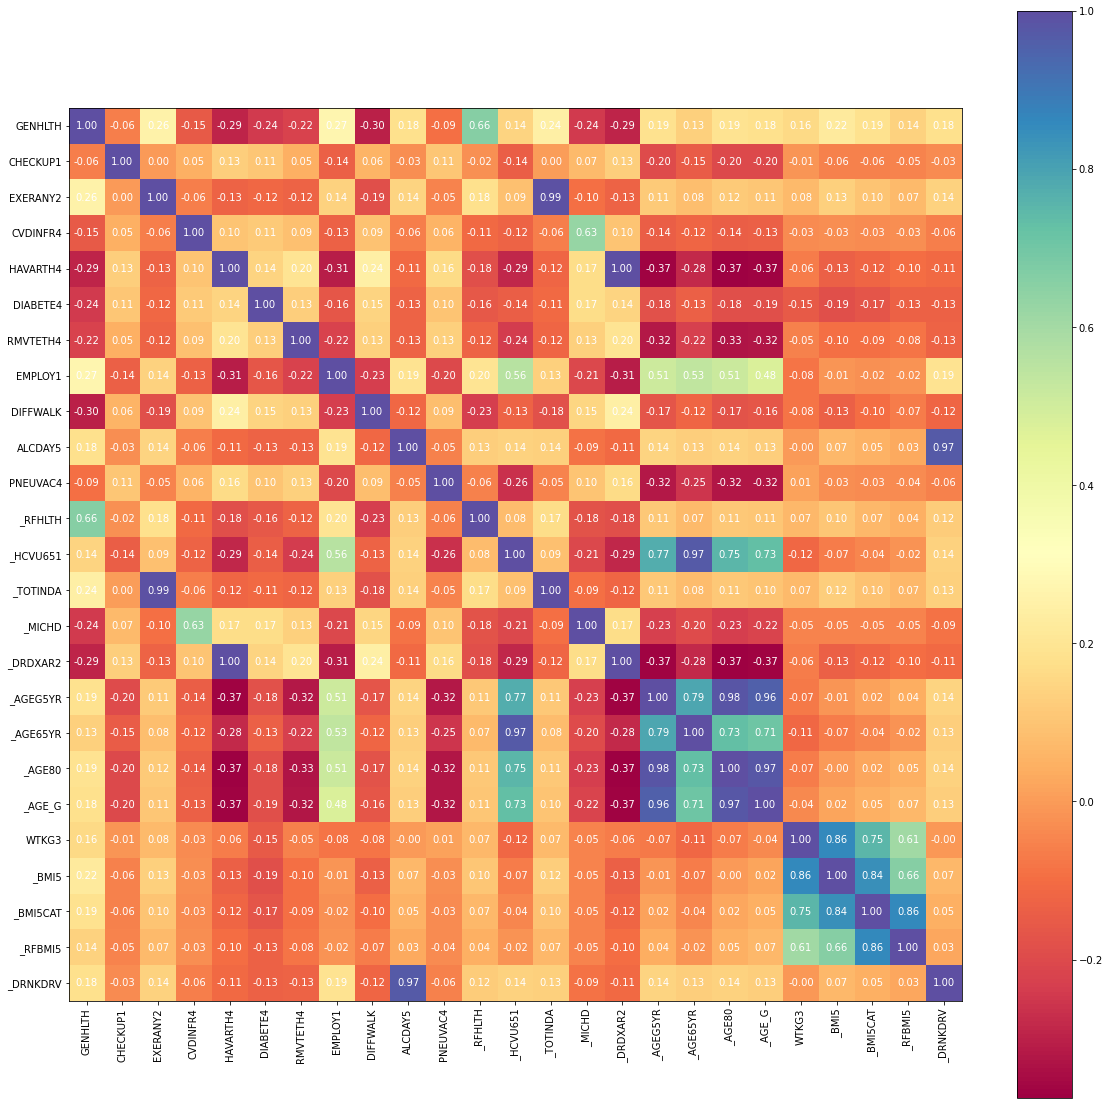

In [13]:
# Plot correaltion heatmap
plt.imshow(corrmatrix, cmap='Spectral')
plt.colorbar()
plt.xticks(range(len(heatmap_sdf.columns)), heatmap_sdf.columns, rotation=90)
plt.yticks(range(len(heatmap_sdf.columns)), heatmap_sdf.columns)
plt.gcf().set_size_inches(20,20)

labels = np.array(heatmap_sdf.collect())

for y in range(labels.shape[0]):
    for x in range(labels.shape[1]):
        plt.text(x, y, '{:.2f}' .format(labels[y, x]), ha='center', va='center', color='white')

#### 2.4.2 Sex of Respondent: the Pie Chart

In [14]:
# Exclude age group 14='No response'
age_not_grp14_sdf = cleaned_sdf.filter(cleaned_sdf['_AGEG5YR'] < 14)
pie_sdf = age_not_grp14_sdf.select('SEXVAR')

In [15]:
# Get group counts for repondent sex
pie_group_sdf = pie_sdf.groupBy('SEXVAR').count().orderBy('count', ascending=True)
pie_group_renamed_sdf = pie_group_sdf.withColumnRenamed('count', 'pop_count')
pie_group_count = pie_group_renamed_sdf.collect()

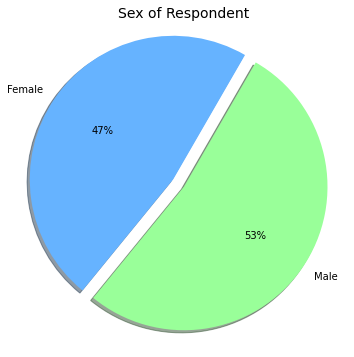

In [16]:
# Pie data prep
pie_data = []

for i in range(len(pie_group_count)):
    pie_data.append(pie_group_count[i].pop_count)

#define color palette to use
colors = ['#66b3ff','#99ff99','#ffcc99','#ff9999']

# define data labels
labels = ['Female', 'Male']

# Create a pieplot
plt.figure(figsize=(6, 6))
plt.pie(pie_data, labels=labels, colors=colors, autopct='%.00f%%' ,radius=1.1 ,shadow=True, explode=[0.1,0], startangle=60)
plt.title("Sex of Respondent", fontdict={'fontsize':14})
plt.show()

#### 2.4.3 Computed Body Mass Index: the Histogram

In [17]:
# Remove outliers (too high BMI)
histo_sdf = cleaned_sdf.filter(cleaned_sdf._BMI5 < 6000)
histo_bmi_vals = histo_sdf.select('_BMI5').collect()

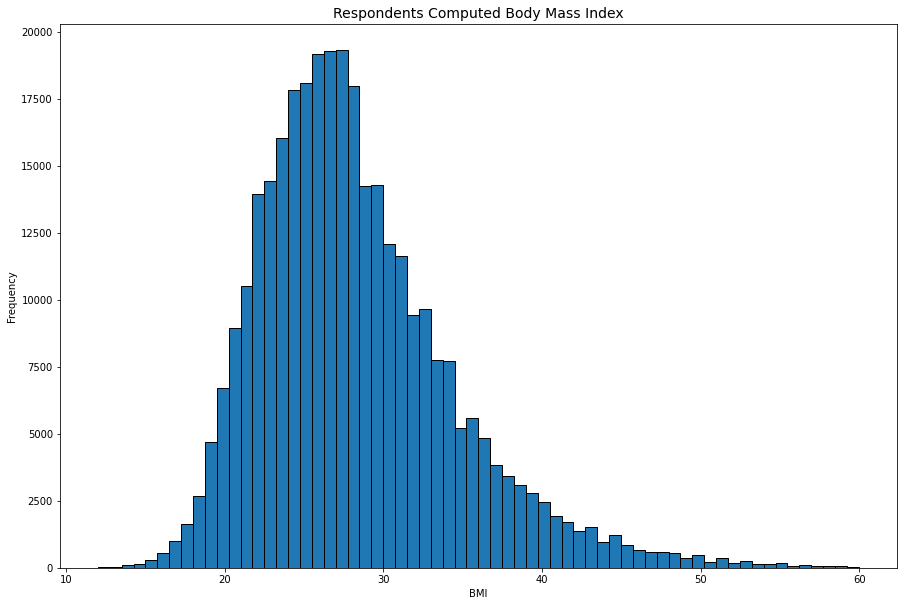

In [18]:
# Histo data prep
hsito_data = []

for i in range(len(histo_bmi_vals)):
    hsito_data.append(histo_bmi_vals[i]._BMI5/100)

hsito_data[:5]

# Plot histogram
counts, bins = np.histogram(hsito_data, bins=64)
plt.figure(figsize=(15, 10))
plt.hist(bins[:-1], bins, weights=counts, ec='black')
plt.title('Respondents Computed Body Mass Index', fontdict={'fontsize':14})
plt.ylabel('Frequency')
plt.xlabel('BMI')
plt.show()

## 3. Data Preparation <a class="anchor" id="data_preparation"></a>

### 3.1 Features Removing
_No additional action needed, because while the EDA we've already removed the features with too many NULLs._

### 3.2 Dataset Cleaning
_No additional action needed, because while the EDA we've already dropped all remaining rows with NULLs._

##### Create backup of the cleaned dataframe, so we can use it while re-runnning and debugging.

In [19]:
# leave cleaned_sdf as backup, so we can re-run many times faster
cleaned_df = cleaned_sdf

print(f'Cleaned number of rows: {cleaned_df.count()}, , number of columns: {len(cleaned_df.columns)}')

Cleaned number of rows: 326959, , number of columns: 112


### 3.3 Feature Selection  <a class="anchor" id="feature_selection"></a>

- We picked fetures according to the absolute correlation coefficients' results >0.1 in the EDA section. Let's apply it here:

In [20]:
# Candidates from correlation coef. >= 0.1:

# +--------+-------------------+
# | feature|      corr_absolute|
# +--------+-------------------+
# | GENHLTH|0.24589367600251408|
# |  _AGE_G|0.19092127239726459|
# |  _AGE80|0.19072694276261376|
# |_AGEG5YR|0.18723669342527285|
# |   _BMI5|0.18616837031030695|
# | EMPLOY1|0.16976771483478573|
# |  _MICHD|0.16944105523216146|
# |_BMI5CAT|0.16832290901401584|
# | _RFHLTH|0.16507734173422267|
# |DIFFWALK|0.15201125568861884|
# |   WTKG3|0.15188968238715578|
# |_DRDXAR2|0.14709958030515652|
# |HAVARTH4|0.14709958030515652|
# |_HCVU651|0.14388852597614002|
# |_AGE65YR|0.14235057094120832|
# |_DRNKDRV|0.13059650197464265|
# | ALCDAY5|0.13001893982345375|
# | _RFBMI5|0.12933584562653766|
# |RMVTETH4|0.12854739562343914|
# |EXERANY2|0.11950726230964258|
# |CVDINFR4| 0.1161998615943308|
# |_TOTINDA|0.11388422824979928|
# |CHECKUP1|0.11007528748766457|
# |PNEUVAC4|0.10258756884001767|
# |_PHYS14D|0.10131009704045844|
# +--------+-------------------+

cols = [
    'GENHLTH',
    '_AGE_G',
    '_BMI5',
    '_AGE80',
    '_AGEG5YR',
    '_BMI5CAT',
    '_MICHD',
    'EMPLOY1',
    '_RFHLTH',
    'WTKG3',
    'DIFFWALK',
    '_DRDXAR2',
    'HAVARTH4',
    '_HCVU651',
    '_AGE65YR',
    '_RFBMI5',
    '_DRNKDRV',
    'ALCDAY5',
    'RMVTETH4',
    'EXERANY2',
    'CVDINFR4',
    '_TOTINDA',
    'CHECKUP1',
    'PNEUVAC4',
    'DIABETE4',
]

# leave only selected columns
df_selected_features = cleaned_df[cols]

##### Take care of the label column:

In [21]:
# rename diabetes column to 'label'
df_selected_features = df_selected_features.withColumnRenamed('DIABETE4', 'label')

# # LEAVE ONLY YES AND NO ANSWERS FOR DIABETES QUESTION
# Label Response Map:
# 1 Yes
# 2 Yes, but female told only during pregnancy
# 3 No
# 4 No, prediabetes or borderline diabetes
# 7 Don’t know / Not sure
# 9 Refused

df_selected_features = df_selected_features.filter((df_selected_features['label']==1)|(df_selected_features['label']==3))  # leave only yes and no

# replace 3s by 0s
df_selected_features = df_selected_features.withColumn("label", when(df_selected_features["label"] == 3, 0).otherwise(df_selected_features["label"]))

# df_selected_features = df_selected_features.na.drop()
df_selected_features.groupby('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    1| 42359|
|    0|274713|
+-----+------+



##### Print questions and possible answers count:

In [22]:
# we'll to feature fransformation in the separate DF
df_features_transformation = df_selected_features

def print_feature_details(columns, n, print_counts=True):
    """
    The function prints info about the feature: question, code, possible responses, counts.
    
    :param list columns: - list of features we work with
    :param int n - index of the feature we want to print info
    :param bool print_counts - True if we wat to print the counts of different responses
    :return: None
    """
    print(columns[n])
    print(labels_map.filter(labels_map['var']==columns[n])[['question']].first())
    question = questions_df.filter((questions_df['VariableName']==columns[n]) & (questions_df['year']==2020))[['Question']].first()
    responses = questions_df.filter((questions_df['VariableName']==columns[n]) & (questions_df['year']==2020))[['Responses']].first()
    print(question)
    print(responses)
    
    if print_counts:
        df_features_transformation.groupBy(columns[n]).count().show()
    else:
        print('-'*20)

In [23]:
for n in range(len(cols)-1):
    print_feature_details(cols, n, print_counts=False)

GENHLTH
Row(question='GENERAL HEALTH')
Row(Question='Would you say that in general your health is:')
Row(Responses='1=Excellent 2=Very good 3=Good 4=Fair 5=Poor 7=Don’t know/Not Sure 9=Refused')
--------------------
_AGE_G
Row(question='IMPUTED AGE IN SIX GROUPS')
None
None
--------------------
_BMI5
Row(question='COMPUTED BODY MASS INDEX')
None
None
--------------------
_AGE80
Row(question='IMPUTED AGE VALUE COLLAPSED ABOVE 80')
None
None
--------------------
_AGEG5YR
Row(question='REPORTED AGE IN FIVE-YEAR AGE CATEGORIES CALCULATED VARIABLE')
None
None
--------------------
_BMI5CAT
Row(question='COMPUTED BODY MASS INDEX CATEGORIES')
None
None
--------------------
_MICHD
Row(question='RESPONDENTS THAT HAVE EVER REPORTED HAVING CORONARY HEART DISEASE (CHD) OR MYOCARDIAL INFARCTION (MI)')
None
None
--------------------
EMPLOY1
Row(question='EMPLOYMENT STATUS')
Row(Question='Are you currently…?')
Row(Responses='1=Employed for wages 2=Self-employed 3=Out of work for 1 year or more 4=Out o

#### **After manually analyzing the variables and removing highly correlated variables (some variables are calculated from others and are linearly dependent), here is the list that we left with:**
- 'GENHLTH' - GENERAL HEALTH
- '_AGE80' - IMPUTED AGE VALUE COLLAPSED ABOVE 80
- '_BMI5' - COMPUTED BODY MASS INDEX
- '_MICHD' - RESPONDENTS THAT HAVE EVER REPORTED HAVING CORONARY HEART DISEASE (CHD) OR MYOCARDIAL INFARCTION (MI)
- 'EMPLOY1' - EMPLOYMENT STATUS
- 'DIFFWALK' - DIFFICULTY WALKING OR CLIMBING STAIRS
- '_DRDXAR2' - RESPONDENTS DIAGNOSED WITH ARTHRITIS
- 'ALCDAY5' - DAYS IN PAST 30 HAD ALCOHOLIC BEVERAGE
- 'RMVTETH4' - NUMBER OF PERMANENT TEETH REMOVED
- 'EXERANY2' - EXERCISE IN PAST 30 DAYS
- 'CHECKUP1' - LENGTH OF TIME SINCE LAST ROUTINE CHECKUP
- 'PNEUVAC4' - PNEUMONIA SHOT EVER
- 'DIABETE4 (label)' - (EVER TOLD) YOU HAD DIABETES

In [24]:
cols_final = [
    'GENHLTH',
    '_AGE80',
    '_BMI5',
    '_MICHD',
    'EMPLOY1',
    'DIFFWALK',
    '_DRDXAR2',
    'ALCDAY5',
    'RMVTETH4',
    'EXERANY2',
    'CHECKUP1',
    'PNEUVAC4',
    'label'
]

df_features_transformation = df_features_transformation[cols_final]

##### Now, let's go through the features one-by-one and make any additional cleaning needed:

In [25]:
n=0
print_feature_details(cols_final, n)

GENHLTH
Row(question='GENERAL HEALTH')
Row(Question='Would you say that in general your health is:')
Row(Responses='1=Excellent 2=Very good 3=Good 4=Fair 5=Poor 7=Don’t know/Not Sure 9=Refused')


+-------+------+
|GENHLTH| count|
+-------+------+
|      1| 65113|
|      3| 92038|
|      5| 11933|
|      9|   160|
|      4| 34981|
|      7|   407|
|      2|112440|
+-------+------+



**Transformation actions:**  
_1. Remove answers 9_  
_2. Apply one-hot encoding to this feature_

In [26]:
df_features_transformation = df_features_transformation.filter(df_features_transformation['GENHLTH']!=9)

***
**Next Feature**
***

In [27]:
n+=1
print_feature_details(cols_final, n)

_AGE80
Row(question='IMPUTED AGE VALUE COLLAPSED ABOVE 80')
None
None


+------+-----+
|_AGE80|count|
+------+-----+
|    31| 3241|
|    65| 7524|
|    53| 4857|
|    78| 4036|
|    34| 3652|
|    28| 3415|
|    76| 4456|
|    27| 3235|
|    26| 3056|
|    44| 3636|
|    22| 3092|
|    47| 4094|
|    52| 5104|
|    40| 4625|
|    20| 2816|
|    57| 5700|
|    54| 4868|
|    48| 4400|
|    19| 2831|
|    64| 6626|
+------+-----+
only showing top 20 rows



**Transformation actions:**  
_Try one hot encoding_

***
**Next Feature**
***

In [28]:
n+=1
print_feature_details(cols_final, n)

_BMI5
Row(question='COMPUTED BODY MASS INDEX')
None
None


+-----+-----+
|_BMI5|count|
+-----+-----+
| 3175|  758|
| 3918|    4|
| 1829|  174|
| 2366|   10|
| 2866|   81|
| 4101|   58|
| 4519|  121|
| 3749|   64|
| 1645|   22|
| 1959|   15|
| 2122|   64|
| 3794|   15|
| 2142|    7|
| 1591|    2|
| 2659|    1|
| 5300|    8|
| 1580|    4|
| 4818|    5|
| 2387|  126|
| 3475|  368|
+-----+-----+
only showing top 20 rows



**Transformation actions:**  
_We'll just apply scaling_  
_Look for outliers_

In [29]:
# remove outliers
df_features_transformation = df_features_transformation.filter(df_features_transformation['_BMI5']<6000)

***
**Next Feature**
***

In [30]:
n+=1
print_feature_details(cols_final, n)

_MICHD
Row(question='RESPONDENTS THAT HAVE EVER REPORTED HAVING CORONARY HEART DISEASE (CHD) OR MYOCARDIAL INFARCTION (MI)')
None
None


+------+------+
|_MICHD| count|
+------+------+
|     1| 27941|
|     2|288525|
+------+------+



**Transformation actions:**  
_1. Replace 2 by 0_

In [31]:
df_features_transformation = df_features_transformation.withColumn("_MICHD", when(df_features_transformation["_MICHD"] == 2, 0).otherwise(df_features_transformation["_MICHD"]))

***
**Next Feature**
***

In [32]:
n+=1
print_feature_details(cols_final, n)

EMPLOY1
Row(question='EMPLOYMENT STATUS')
Row(Question='Are you currently…?')
Row(Responses='1=Employed for wages 2=Self-employed 3=Out of work for 1 year or more 4=Out of work for less than 1 year 5=A homemaker 6=A student 7=Retired 8=Unable to work 9=Refused')


+-------+------+
|EMPLOY1| count|
+-------+------+
|      1|132701|
|      6|  8820|
|      3|  5321|
|      5| 12042|
|      9|  1930|
|      4| 12578|
|      8| 19575|
|      7| 95351|
|      2| 28148|
+-------+------+



**Transformation actions:**   
_1. Remove 9_

In [33]:
df_features_transformation = df_features_transformation.filter(df_features_transformation['EMPLOY1']!=9)

***
**Next Feature**
***

In [34]:
n+=1
print_feature_details(cols_final, n)

DIFFWALK
Row(question='DIFFICULTY WALKING OR CLIMBING STAIRS')
Row(Question='Do you have serious difficulty walking or climbing stairs?')
Row(Responses='1=Yes 2=No 7=Don’t know/Not Sure 9=Refused')


+--------+------+
|DIFFWALK| count|
+--------+------+
|       1| 45128|
|       9|   112|
|       7|   709|
|       2|268587|
+--------+------+



**Transformation actions:**   
_1. Remove 9_

In [35]:
df_features_transformation = df_features_transformation.filter(df_features_transformation['DIFFWALK']!=9)

***
**Next Feature**
***

In [36]:
n+=1
print_feature_details(cols_final, n)

_DRDXAR2
Row(question='RESPONDENTS DIAGNOSED WITH ARTHRITIS')
None
None


+--------+------+
|_DRDXAR2| count|
+--------+------+
|       1| 99442|
|       2|214982|
+--------+------+



**Transformation actions:**  
_1. Replace 2 by 0_

In [37]:
df_features_transformation = df_features_transformation.withColumn("_DRDXAR2", when(df_features_transformation["_DRDXAR2"] == 2, 0).otherwise(df_features_transformation["_DRDXAR2"]))

***
**Next Feature**
***

In [38]:
n+=1
print_feature_details(cols_final, n)

ALCDAY5
Row(question='DAYS IN PAST 30 HAD ALCOHOLIC BEVERAGE')
Row(Question='During the past 30 days, how many days per week or per month did you have at least one drink of any alcoholic beverage such as beer, wine, a malt beverage or liquor?')
Row(Responses='101-107=Days per week 201-230=Days in past 30 days 888=No drinks in past 30 days 777=Don’t know/Not sure 999=Refused')


+-------+-----+
|ALCDAY5|count|
+-------+-----+
|    211|   51|
|    101|13408|
|    210| 7054|
|    103| 7988|
|    223|   78|
|    222|  150|
|    209|  216|
|    230|13733|
|    225| 2747|
|    224|  155|
|    206| 3242|
|    777| 2532|
|    212| 1558|
|    218|  213|
|    205| 8656|
|    227|  232|
|    207| 2298|
|    202|17826|
|    107| 5981|
|    217|   90|
+-------+-----+
only showing top 20 rows



**Transformation actions:**   
_1. Remove 999_  
_2. Replace 888 by 0_

In [39]:
df_features_transformation = df_features_transformation.filter(df_features_transformation['ALCDAY5']!=999)
df_features_transformation = df_features_transformation.withColumn("ALCDAY5", when(df_features_transformation["ALCDAY5"] == 888, 0).otherwise(df_features_transformation["ALCDAY5"]))

***
**Next Feature**
***

In [40]:
n+=1
print_feature_details(cols_final, n)

RMVTETH4
Row(question='NUMBER OF PERMANENT TEETH REMOVED')
Row(Question='Not including teeth lost for injury or orthodontics, how many of your permanent teeth have been removed because of tooth decay or gum disease?')
Row(Responses='1=1 to 5 2=6 or more, but not all 3=All 8=None 7=Don’t know/Not sure 9=Refused')


+--------+------+
|RMVTETH4| count|
+--------+------+
|       1| 90164|
|       3| 19432|
|       9|   364|
|       8|164706|
|       7|  5821|
|       2| 32998|
+--------+------+



**Transformation actions:**   
_1. Remove 9_  
_2. Replace 8 by 0_

In [41]:
df_features_transformation = df_features_transformation.filter(df_features_transformation['RMVTETH4']!=9)
df_features_transformation = df_features_transformation.withColumn("RMVTETH4", when(df_features_transformation["RMVTETH4"] == 8, 0).otherwise(df_features_transformation["RMVTETH4"]))

***
**Next Feature**
***

In [42]:
n+=1
print_feature_details(cols_final, n)

EXERANY2
Row(question='EXERCISE IN PAST 30 DAYS')
Row(Question='During the past month, other than your regular job, did you participate in any physical activities or exercises such as running, calisthenics, golf, gardening, or walking for exercise?')
Row(Responses='1=Yes 2=No 7=Don’t know/Not Sure 9=Refused')


+--------+------+
|EXERANY2| count|
+--------+------+
|       1|242555|
|       9|    87|
|       7|   302|
|       2| 70177|
+--------+------+



**Transformation actions:**   
_1. Remove 9_ 

In [43]:
df_features_transformation = df_features_transformation.filter(df_features_transformation['EXERANY2']!=9)

***
**Next Feature**
***

In [44]:
n+=1
print_feature_details(cols_final, n)

CHECKUP1
Row(question='LENGTH OF TIME SINCE LAST ROUTINE CHECKUP')
Row(Question='About how long has it been since you last visited a doctor for a routine checkup?')
Row(Responses='1=Within past year (anytime less than 12 months ago) 2=Within past 2 years (1 year but less than 2 years ago) 3=Within past 5 years (2 years but less than 5 years ago) 4=5 or more years ago 7=Don’t know/Not sure 8=Never 9=Refused')


+--------+------+
|CHECKUP1| count|
+--------+------+
|       1|242338|
|       3| 16221|
|       9|   228|
|       4| 14400|
|       8|  1421|
|       7|  2925|
|       2| 35501|
+--------+------+



**Transformation actions:**   
_1. Remove 9_  
_2. Replace 8 by 0_

In [45]:
df_features_transformation = df_features_transformation.filter(df_features_transformation['CHECKUP1']!=9)
df_features_transformation = df_features_transformation.withColumn("CHECKUP1", when(df_features_transformation["CHECKUP1"] == 8, 0).otherwise(df_features_transformation["CHECKUP1"]))

***
**Next Feature**
***

In [46]:
n+=1
print_feature_details(cols_final, n)

PNEUVAC4
Row(question='PNEUMONIA SHOT EVER')
Row(Question='Have you ever had a pneumonia shot also known as a pneumococcal vaccine?')
Row(Responses='1=Yes 2=No 7=Don’t know/Not Sure 9=Refused')


+--------+------+
|PNEUVAC4| count|
+--------+------+
|       1|118534|
|       9|   103|
|       7| 25760|
|       2|168409|
+--------+------+



**Transformation actions:**   
_1. Remove 9_  

In [47]:
df_features_transformation = df_features_transformation.filter(df_features_transformation['PNEUVAC4']!=9)

***
##### Take a final look on the dataset:

In [48]:
df_features_transformation.groupby('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    1| 41786|
|    0|270917|
+-----+------+



##### We have highly imbalanced dataset. Let's balance it:

In [49]:
temp = df_features_transformation.sampleBy('label', fractions={1: 1, 0: 0.1541}, seed=42)
temp.count()
temp.groupby('label').count().show()
df_features_transformation = temp

+-----+-----+
|label|count|
+-----+-----+
|    1|41786|
|    0|41769|
+-----+-----+



In [50]:
print('Final number of rows:',df_features_transformation.count())
print('Final number of columns:',len(df_features_transformation.columns))

Final number of rows: 83555
Final number of columns: 13


### 3.4 Feature Transformation <a class="anchor" id="feature_transformation"></a>

In [51]:
# do backup for using with models, that don't require one-hot encoding and scaling
df_features_transformation_backup = df_features_transformation

##### One-hot encoding

In [52]:
# df_features_transformation = df_features_transformation_backup

# columns to transform
one_hot_cols_inp = ['GENHLTH', 'EMPLOY1', 'DIFFWALK', 'RMVTETH4', 'EXERANY2', 'CHECKUP1', 'PNEUVAC4']
# transformed colums will have '_OH' suffix in the name
one_hot_cols_outp = [x+'_OH' for x in one_hot_cols_inp]

# do the transformation
encoder = OneHotEncoder(
    inputCols=one_hot_cols_inp,  
    outputCols=one_hot_cols_outp
)
model = encoder.fit(df_features_transformation)
df_features_transformation = model.transform(df_features_transformation)

# drop original columns
df_features_transformation = df_features_transformation.drop(*one_hot_cols_inp)

df_features_transformation.show(1)

+------+-----+------+--------+-------+-----+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|_AGE80|_BMI5|_MICHD|_DRDXAR2|ALCDAY5|label|   GENHLTH_OH|   EMPLOY1_OH|  DIFFWALK_OH|  RMVTETH4_OH|  EXERANY2_OH|  CHECKUP1_OH|  PNEUVAC4_OH|
+------+-----+------+--------+-------+-----+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|    56| 1660|     0|       1|      0|    1|(7,[2],[1.0])|(8,[4],[1.0])|(7,[2],[1.0])|(7,[2],[1.0])|(7,[1],[1.0])|(7,[4],[1.0])|(7,[2],[1.0])|
+------+-----+------+--------+-------+-----+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
only showing top 1 row



##### Logistic Regession and LSVM Models: Test/Training Data Splitting,  Scaling, Normalizing

In [53]:
# assemble all features in vector
col_feature_names = list(df_features_transformation.columns)
col_feature_names.remove('label')
vecAssembler = VectorAssembler(inputCols = col_feature_names, outputCol="features_unscaled")
df_features_transformation_unscaled = vecAssembler.transform(df_features_transformation)

# Generalization: split to test and train dataframes
train, test = df_features_transformation_unscaled.randomSplit([0.8, 0.2], seed=42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

# scale data
standardScaler = StandardScaler(inputCol='features_unscaled', outputCol='features_scaled', withMean=True, withStd=True)
model = standardScaler.fit(train)
scaled_train = model.transform(train)
scaled_test= model.transform(test)

# normalize data
normalizer = Normalizer(p=2.0, inputCol='features_scaled', outputCol='features')
scaled_train = normalizer.transform(scaled_train)
scaled_test= normalizer.transform(scaled_test)

scaled_train.show(1)

Training Dataset Count: 67034


Test Dataset Count: 16521


+------+-----+------+--------+-------+-----+-------------+-------------+-------------+-----------+-------------+-------------+-----------+--------------------+--------------------+--------------------+
|_AGE80|_BMI5|_MICHD|_DRDXAR2|ALCDAY5|label|   GENHLTH_OH|   EMPLOY1_OH|  DIFFWALK_OH|RMVTETH4_OH|  EXERANY2_OH|  CHECKUP1_OH|PNEUVAC4_OH|   features_unscaled|     features_scaled|            features|
+------+-----+------+--------+-------+-----+-------------+-------------+-------------+-----------+-------------+-------------+-----------+--------------------+--------------------+--------------------+
|    18| 1481|     0|       0|      0|    0|(7,[4],[1.0])|(8,[6],[1.0])|(7,[2],[1.0])|  (7,[],[])|(7,[2],[1.0])|(7,[1],[1.0])|  (7,[],[])|(55,[0,1,9,18,22,...|[-2.4766451356534...|[-0.2697300683538...|
+------+-----+------+--------+-------+-----+-------------+-------------+-------------+-----------+-------------+-------------+-----------+--------------------+--------------------+------------

##### Tree Based Models: Test/Training Data Splitting, Feature Indexing

In [54]:
# make backup of data for many cycles of running
df_features_transformation_backup1 = df_features_transformation_backup
data = df_features_transformation_backup1

# assemble all features in vector
col_feature_names = list(data.columns)
col_feature_names.remove('label')
vec_assembler = VectorAssembler(inputCols = col_feature_names, outputCol="features")
data = vec_assembler.transform(data)

# to recognize categorical features
feature_indexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=10)
data = feature_indexer.fit(data).transform(data)

# drop features columns
data = data.drop(*col_feature_names, 'features')

# Split the data
(train_data, test_data) = data.randomSplit([0.8, 0.2], seed=42)

## 4. Modeling <a class="anchor" id="modeling"></a>

##### The function for models evaluation

In [55]:
def evaluate(model, predictions_df, label='', model_name=''):
    """
    The function calculates the evaluation metrics for the models.
    
    :param Model Object model: - model object after fitting the data
    :param DataFrame predictions_df - DataFrame with label and predicted values
    :param str label - the name of column with labels
    :param str model_name - name of the model for priting the title
    :return: None
    """
    #  replace 0s with 2, to get correct confusion matrix
    preds_and_labels = predictions_df.select(['prediction',label])
    preds_and_labels = preds_and_labels.withColumn("prediction",when(preds_and_labels.prediction == 0,2).otherwise(1))
    preds_and_labels = preds_and_labels.withColumn(label,when(preds_and_labels[label] == 0,2).otherwise(1))

    # cast to float
    preds_and_labels = preds_and_labels.select(['prediction',label]).withColumn(label, pyspark.sql.functions.col(label).cast(FloatType())).orderBy('prediction')
    preds_and_labels = preds_and_labels.select(['prediction',label]).withColumn('prediction', pyspark.sql.functions.col('prediction').cast(FloatType())).orderBy('prediction')

    pred_and_labels_rdd = preds_and_labels.rdd.map(tuple)
    
    metrics = MulticlassMetrics(pred_and_labels_rdd)
    metrics.confusionMatrix().toArray()
    
    print(f"Evaluation of {model_name}")
    print("accuracy:",metrics.accuracy)
    print("test error:",(1 - metrics.accuracy))
    print("precision:",metrics.precision(2))
    print("recall:",metrics.recall(2))
    print("\n confusionMatrix:\n",metrics.confusionMatrix().toArray(),'\n')
    print("fMeasure:" ,metrics.fMeasure(2.0, 1.0))


### 4.1 Logistic Regression  <a class="anchor" id="log_reg"></a>
#### Tune Decision Tree Model:
- Fit model to train data
- Use KFold Cross Validation K=10
- Iterate through different combinations of hyperparameters to find the best metric

In [56]:
# This code is commented out, because it can take hours to run it. The output is provided in the next merkdown cell.

# %%time

# lr_model = LogisticRegression(featuresCol ='features',labelCol='label') 

# # Sequence stages
# pipeline = Pipeline(stages=[lr_model])

# # Hyper parameter tuning
# lr_param_grid = ParamGridBuilder()\
#             .addGrid(lr_model.elasticNetParam,[0.0, 0.5, 1.0])\
#             .addGrid(lr_model.fitIntercept,[False, True])\
#             .addGrid(lr_model.maxIter,[10, 30, 50, 1000])\
#             .addGrid(lr_model.family, ['binomial']) \
#             .addGrid(lr_model.regParam, [0.0001, 0.001, 0.1, 1.0, 2.0]) \
#             .build()

# # Cross validation
# lr_cross_val = CrossValidator(estimator = pipeline,
#                          estimatorParamMaps = lr_param_grid,
#                          evaluator = BinaryClassificationEvaluator(),
#                          numFolds = 10)

# lr_fit_model = lr_cross_val.fit(scaled_train)

# # Best model params:
# best_params_idx = np.argmax(lr_fit_model.avgMetrics)
# print(f"{lr_param_grid[best_params_idx]} \nAVG Metric: {lr_fit_model.avgMetrics[best_params_idx]}\n")

##### NOTE: THIS IS SAVED OUTPUT. RE-RUNNING THE CELL CAN TAKE HOURS:**

{Param(parent='LogisticRegression_b52edbd3bc0f', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0, Param(parent='LogisticRegression_b52edbd3bc0f', name='fitIntercept', doc='whether to fit an intercept term.'): False, Param(parent='LogisticRegression_b52edbd3bc0f', name='maxIter', doc='max number of iterations (>= 0).'): 30, Param(parent='LogisticRegression_b52edbd3bc0f', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'binomial', Param(parent='LogisticRegression_b52edbd3bc0f', name='regParam', doc='regularization parameter (>= 0).'): 0.0001} 
AVG Metric: 0.8267837084585531

CPU times: user 26 s, sys: 15.3 s, total: 41.4 s
Wall time: 45min 47s

##### Evaluate the model with unseen data and best hyperparameters combination

In [57]:
# Cross validation
best_lr_model = LogisticRegression(featuresCol ='features'
                              ,labelCol='label',maxIter=30, regParam=0.0001, family= 'binomial'
                              ,fitIntercept=False , elasticNetParam=1.0).fit(scaled_train)

best_lr_preds_train = best_lr_model.transform(scaled_train)
best_lr_preds_test = best_lr_model.transform(scaled_test)

evaluate(best_lr_model, best_lr_preds_train, 'label', 'Logistic Regression Train Data')
evaluate(best_lr_model, best_lr_preds_test, 'label', 'Logistic Regression Test Data')

Evaluation of Logistic Regression Train Data
accuracy: 0.7505892532147865
test error: 0.24941074678521347
precision: 0.7746986777557584
recall: 0.7090692833779364

 confusionMatrix:
 [[26469.  6935.]
 [ 9784. 23846.]] 

fMeasure: 0.7404325348154819


Evaluation of Logistic Regression Test Data
accuracy: 0.752678409297258
test error: 0.24732159070274196
precision: 0.7715395953369959
recall: 0.7074579186632265

 confusionMatrix:
 [[6677. 1705.]
 [2381. 5758.]] 

fMeasure: 0.7381104986540187


### 4.2 Linear SVM  <a class="anchor" id="lsvm"></a>
#### Tune Linear SVM  Model:
- Fit model to train data
- Use KFold Cross Validation K=10
- Iterate through different combinations of hyperparameters to find the best metric

In [58]:
# This code is commented out, because it can take hours to run it. The output is provided in the next merkdown cell.

# %%time
# lsvc_model = LinearSVC(featuresCol ='features',labelCol='label')

# # Sequence stages
# pipeline = Pipeline(stages=[lsvc_model])

# # Hyper parameter tuning
# lsvc_param_grid = ParamGridBuilder()\
#             .addGrid(lsvc_model.threshold,[0.0,0.1, 0.2])\
#             .addGrid(lsvc_model.aggregationDepth, [2,4,6])\
#             .addGrid(lsvc_model.tol,[0.001, 0.1, 1.0])\
#             .addGrid(lsvc_model.regParam, [0.0001, 0.001, 0.1, 1.0, 10.0]) \
#             .addGrid(lsvc_model.fitIntercept,[False, True])\
#             .addGrid(lsvc_model.maxIter,[100, 1000, 10000])\
#             .build()

# # Cross validation
# lsvc_cross_val = CrossValidator(estimator = pipeline,
#                          estimatorParamMaps = lsvc_param_grid,
#                          evaluator = BinaryClassificationEvaluator(),
#                          numFolds = 10)

# lsvc_fit_model = lsvc_cross_val.fit(scaled_train)

# # Best model params:
# lsvc_best_params_idx = np.argmax(lsvc_fit_model.avgMetrics)
# print(f"{lsvc_param_grid[lsvc_best_params_idx]} \nAVG Metric: {lsvc_fit_model.avgMetrics[lsvc_best_params_idx]}\n")

##### NOTE: THIS IS SAVED OUTPUT. RE-RUNNING THE CELL CAN TAKE HOURS:**

{Param(parent='LinearSVC_58ed1f58e665', name='threshold', doc='The threshold in binary classification applied to the linear model prediction.  This threshold can be any real number, where Inf will make all predictions 0.0 and -Inf will make all predictions 1.0.'): 0.0, Param(parent='LinearSVC_58ed1f58e665', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 6, Param(parent='LinearSVC_58ed1f58e665', name='tol', doc='the convergence tolerance for iterative algorithms (>= 0).'): 0.001, Param(parent='LinearSVC_58ed1f58e665', name='regParam', doc='regularization parameter (>= 0).'): 0.0001, Param(parent='LinearSVC_58ed1f58e665', name='fitIntercept', doc='whether to fit an intercept term.'): False, Param(parent='LinearSVC_58ed1f58e665', name='maxIter', doc='max number of iterations (>= 0).'): 1000} 
AVG Metric: 0.8259948979482298

CPU times: user 2min 18s, sys: 1min 33s, total: 3min 52s
Wall time: 2h 11s

##### Test with unseen data and best hyperparameters combination

In [59]:
best_lsvc_model = LinearSVC(regParam=0.0001, threshold=0, aggregationDepth=6, tol=0.001,
                           fitIntercept=False, maxIter=1000).fit(scaled_train)

best_lsvc_predictions_train = best_lsvc_model.transform(scaled_train)
best_lsvc_predictions_test = best_lsvc_model.transform(scaled_test)

evaluate(best_lsvc_model, best_lsvc_predictions_train, 'label', 'Linear SVM Train Data')
evaluate(best_lsvc_model, best_lsvc_predictions_test, 'label', 'Linear SVM Test Data')

Evaluation of Linear SVM Train Data
accuracy: 0.7503654861711967
test error: 0.2496345138288033
precision: 0.7752329445494234
recall: 0.7075527802557241

 confusionMatrix:
 [[26505.  6899.]
 [ 9835. 23795.]] 

fMeasure: 0.7398482681425285


Evaluation of Linear SVM Test Data
accuracy: 0.7520125900369227
test error: 0.24798740996307733
precision: 0.7716397849462365
recall: 0.7053692099766556

 confusionMatrix:
 [[6683. 1699.]
 [2398. 5741.]] 

fMeasure: 0.7370177803453366


### 4.3 Decision Tree  <a class="anchor" id="dtree"></a>

#### Tune Decision Tree Model:
- Fit model to train data
- Use KFold Cross Validation K=10
- Iterate through different combinations of hyperparameters to find the best metric

In [60]:
# This code is commented out, because it can take hours to run it. The output is provided in the next merkdown cell.

# %%time
# # base model
# dt_model = DecisionTreeClassifier(labelCol="label", featuresCol="indexedFeatures")

# # Sequence stages
# # pipeline = Pipeline(stages=[dt])

# '''
# class pyspark.ml.classification.DecisionTreeClassifier(*, featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability', 
# rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, 
# checkpointInterval=10, impurity='gini', seed=None, weightCol=None, leafCol='', minWeightFractionPerNode=0.0)[source]
# '''

# # create combinations of hyperparameters
# dt_param_grid = ParamGridBuilder()\
#             .addGrid(dt_model.maxBins,[8, 16, 32, 64])\
#             .addGrid(dt_model.minInstancesPerNode,[10, 100, 200, 500])\
#             .build()

# # cross validation
# dt_cross_val = CrossValidator(estimator = dt_model,
#                          estimatorParamMaps = dt_param_grid,
#                          evaluator = BinaryClassificationEvaluator(),
#                          # evaluator = MulticlassClassificationEvaluator(),
#                          numFolds = 10)

# # run the model selection
# cv_model = dt_cross_val.fit(train_data)

# # Best model params:
# best_params_idx = np.argmax(cv_model.avgMetrics)
# print(f"{dt_param_grid[best_params_idx]} \nAVG Metric: {cv_model.avgMetrics[best_params_idx]}\n")

##### NOTE: THIS IS SAVED OUTPUT. RE-RUNNING THE CELL CAN TAKE HOURS:**


{Param(parent='DecisionTreeClassifier_4ee9c31e61a2', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='DecisionTreeClassifier_4ee9c31e61a2', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 64, Param(parent='DecisionTreeClassifier_4ee9c31e61a2', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 100} 
AVG Metric: 0.7526668075497813

CPU times: user 8.68 s, sys: 6.62 s, total: 15.3 s
Wall time: 5min 30s

##### Test with unseen data and best hyperparameters combination

In [61]:
# Train a model with the best parameters
# Note: manually found, that max_depth=15 increseases the accuracy and f-score.
best_dtree_model = DecisionTreeClassifier(labelCol="label", featuresCol="indexedFeatures", maxDepth=15, maxBins=64, minInstancesPerNode=100).fit(train_data)

# Make predictions.
best_dtree_predictions_train = best_dtree_model.transform(train_data)
best_dtree_predictions_test = best_dtree_model.transform(test_data)

# evaluate
evaluate(best_dtree_model, best_dtree_predictions_train, 'label', 'Decision Tree Train Data')
evaluate(best_dtree_model, best_dtree_predictions_test, 'label', 'Decision Tree Test Data')

Evaluation of Decision Tree Train Data
accuracy: 0.7571232508876092
test error: 0.24287674911239077
precision: 0.7804585789235055
recall: 0.7172107972976994

 confusionMatrix:
 [[26654.  6779.]
 [ 9502. 24099.]] 

fMeasure: 0.7474991857814172


Evaluation of Decision Tree Test Data
accuracy: 0.7440227589128987
test error: 0.2559772410871013
precision: 0.7617275747508305
recall: 0.7017629774730656

 confusionMatrix:
 [[6560. 1793.]
 [2436. 5732.]] 

fMeasure: 0.7305167909258905


### 4.4 Gradient Boosted Tree Classifier <a class="anchor" id="gbtc"></a>
#### Tune GBT Model:
- Fit model to train data
- Use KFold Cross Validation K=10
- Iterate through different combinations of hyperparameters to find the best metric

In [62]:
# This code is commented out, because it can take hours to run it. The output is provided in the next merkdown cell.

# %%time

# # Train a GBT model.
# gbt_model = GBTClassifier(labelCol="label", featuresCol="indexedFeatures")

# '''
# class pyspark.ml.classification.GBTClassifier(*, featuresCol='features', labelCol='label', predictionCol='prediction', maxDepth=5, maxBins=32, 
# minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, lossType='logistic', maxIter=20, stepSize=0.1, seed=None, 
# subsamplingRate=1.0, impurity='variance', featureSubsetStrategy='all', validationTol=0.01, validationIndicatorCol=None, leafCol='', 
# minWeightFractionPerNode=0.0, weightCol=None)[source]
# '''

# # create combinations of hyperparameters
# param_grid = ParamGridBuilder()\
#             .addGrid(gbt_model.maxDepth,[10, 30])\
#             .addGrid(gbt_model.minInstancesPerNode,[100, 200, 300, 400, 500, 1000])\
#             .addGrid(gbt_model.maxBins,[10])\
#             .addGrid(gbt_model.maxIter, [20,30,40,50,100])\
#             .build()

# # cross validation
# gbt_cross_val = CrossValidator(estimator = gbt_model,
#                          estimatorParamMaps = param_grid,
#                          evaluator = BinaryClassificationEvaluator(),
#                          # evaluator = MulticlassClassificationEvaluator(),
#                          numFolds = 10)

# # run the model selection
# cv_model = gbt_cross_val.fit(train_data)

# # Best model params:
# best_params_idx = np.argmax(cv_model.avgMetrics)
# print(f"{param_grid[best_params_idx]} \nAVG Metric: {cv_model.avgMetrics[best_params_idx]}\n")

##### NOTE: THIS IS SAVED OUTPUT. RE-RUNNING THE CELL CAN TAKE HOURS:**

{Param(parent='GBTClassifier_742a8b407c15', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 30, Param(parent='GBTClassifier_742a8b407c15', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1000, Param(parent='GBTClassifier_742a8b407c15', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 10, Param(parent='GBTClassifier_742a8b407c15', name='maxIter', doc='max number of iterations (>= 0).'): 100} 
AVG Metric: 0.832474376023306

CPU times: user 700 ms, sys: 292 ms, total: 993 ms
Wall time: 11min 18s

##### Test with unseen data and best hyperparameters combination

In [63]:
# Train a model with the best parameters
best_gbt_model = GBTClassifier(labelCol="label", featuresCol="indexedFeatures", maxDepth=30, maxBins=10, minInstancesPerNode=1000, maxIter=100).fit(train_data)

# Make predictions.
best_gbt_predictions_train = best_gbt_model.transform(train_data)
best_gbt_predictions_test = best_gbt_model.transform(test_data)

# evaluate
evaluate(best_gbt_model, best_gbt_predictions_train, 'label', 'GBT Classifier Train Data')
evaluate(best_gbt_model, best_gbt_predictions_test, 'label', 'GBT Classifier Test Data')

Evaluation of GBT Classifier Train Data
accuracy: 0.76619327505445
test error: 0.23380672494555
precision: 0.792291639493935
recall: 0.7231332400821404

 confusionMatrix:
 [[27063.  6370.]
 [ 9303. 24298.]] 

fMeasure: 0.7561343727146835


Evaluation of GBT Classifier Test Data
accuracy: 0.7521941771079232
test error: 0.24780582289207675
precision: 0.7708776595744681
recall: 0.709720861900098

 confusionMatrix:
 [[6630. 1723.]
 [2371. 5797.]] 

fMeasure: 0.7390362060173382


### 4.5 Random Forest Classifier <a class="anchor" id="rfc"></a>
#### Tune RF Model:
- Fit model to train data
- Use KFold Cross Validation K=10
- Iterate through different combinations of hyperparameters to find the best metric

In [64]:
# This code is commented out, because it can take hours to run it. The output is provided in the next merkdown cell.

# %%time

# # Train a RandomForest model.
# rf_model = RandomForestClassifier(labelCol="label", featuresCol="indexedFeatures", numTrees=30)


# '''
# class pyspark.ml.classification.RandomForestClassifier(*, featuresCol='features', labelCol='label', predictionCol='prediction', 
# probabilityCol='probability', rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, 
# maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, 
# impurity='gini', numTrees=20, featureSubsetStrategy='auto', seed=None, subsamplingRate=1.0, leafCol='', minWeightFractionPerNode=0.0, weightCol=None, bootstrap=True)[source]
# '''

# # create combinations of hyperparameters
# rf_param_grid = ParamGridBuilder()\
#             .addGrid(rf_model.maxDepth,[5, 10, 30])\
#             .addGrid(rf_model.maxBins,[8, 16])\
#             .addGrid(rf_model.numTrees,[5, 10, 30])\
#             .addGrid(rf_model.minInstancesPerNode,[10, 100, 200])\
#             .build()

# # cross validation
# rf_cross_val = CrossValidator(estimator = rf_model,
#                          estimatorParamMaps = rf_param_grid,
#                          evaluator = MulticlassClassificationEvaluator(),
#                          numFolds = 10)

# # run the model selection
# cv_model = rf_cross_val.fit(train_data)

# # Best model params:
# best_params_idx = np.argmax(cv_model.avgMetrics)
# print(f"{rf_param_grid[best_params_idx]} \nAVG Metric: {cv_model.avgMetrics[best_params_idx]}\n")

##### NOTE: THIS IS SAVED OUTPUT. RE-RUNNING THE CELL CAN TAKE HOURS:**

{Param(parent='RandomForestClassifier_3a6bc948267d', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 10, Param(parent='RandomForestClassifier_3a6bc948267d', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 16, Param(parent='RandomForestClassifier_3a6bc948267d', name='numTrees', doc='Number of trees to train (>= 1).'): 30, Param(parent='RandomForestClassifier_3a6bc948267d', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 10} 
AVG Metric: 0.7535031084760802

##### Test with unseen data and best hyperparameters combination

In [65]:
# Train a model with the best parameters
best_rf_model = RandomForestClassifier(labelCol="label", featuresCol="indexedFeatures", maxDepth=10, maxBins=16, minInstancesPerNode=10, numTrees=30).fit(train_data)

# Make predictions.
best_rf_predictions_train = best_rf_model.transform(train_data)
best_rf_predictions_test = best_rf_model.transform(test_data)

# evaluate
evaluate(best_rf_model, best_rf_predictions_train, 'label', 'Random forest Classifier Train Data')
evaluate(best_rf_model, best_rf_predictions_test, 'label', 'Random forest Classifier Test Data')

Evaluation of Random forest Classifier Train Data
accuracy: 0.7655219739236805
test error: 0.2344780260763195
precision: 0.7965966762861977
recall: 0.714710871700247

 confusionMatrix:
 [[27301.  6132.]
 [ 9586. 24015.]] 

fMeasure: 0.7534354018949616


Evaluation of Random forest Classifier Test Data
accuracy: 0.7524362932025906
test error: 0.24756370679740936
precision: 0.7769627818527574
recall: 0.7002938295788442

 confusionMatrix:
 [[6711. 1642.]
 [2448. 5720.]] 

fMeasure: 0.7366387636831938


## 5. Results Evaluation <a class="anchor" id="evaluation"></a>
### 5.1 Selection of the Best Model


- Healthcare Industry: the Recall metric would be the most appropriate because it is very important to identify as many individuals as possible at risk.**
- Insurance Industry: the combination of Presicion and Accuracy metrics would be better, because insurance companies want to predict non-risk individuals as well.**

**For both industries, the Gradient Boosted Tree Classifier model looks the best among all that we tried:**
```
Evaluation of GBT Classifier Train Data
accuracy: 0.76619327505445
test error: 0.23380672494555
precision: 0.792291639493935
recall: 0.7231332400821404

 confusionMatrix:
 [[27063.  6370.]
 [ 9303. 24298.]] 

fMeasure: 0.7561343727146835
                                                                                
Evaluation of GBT Classifier Test Data
accuracy: 0.7521941771079232
test error: 0.24780582289207675
precision: 0.7708776595744681
recall: 0.709720861900098

 confusionMatrix:
 [[6630. 1723.]
 [2371. 5797.]] 

fMeasure: 0.7390362060173382
```

### 5.2 ROC Curves for Train and Test Data <a class="anchor" id="roc"></a>
##### Function to plot the ROC curves for several models at once:

In [75]:
# this code was taken and modified per our needs from:
# https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)    
    
    
def plot_roc(args, title):
    """
    The function plots ROC Curve graph for the models.
    
    :param list args: - list of argument lists to plot several graphs at once. Each list of arguments contains: 
        Model Object model: - model object after fitting the data
        DataFrame predictions_df - DataFrame with label and predicted values
        str label - the name of column with labels
        str model_name - name of the model for printing the title
        str model_type - type of the model ('tree' for DecisionTree, RandomForest and Gradient Tree Booster)
        :param str title - type of the model ('tree' for DecisionTree, RandomForest and Gradient Tree Booster)
    :return: None
    """
    plt.figure(figsize=(15, 15))
    
    # plot each model ROC curve in one graph
    for arg in args:
       
        model, predictions_df, label, model_name, model_type = arg

        #  replace 0s with 2, to get correct confusion matrix
        print('Creating plot for:', model_name)

        preds_and_labels = predictions_df.select(['prediction',label])
        preds_and_labels = preds_and_labels.withColumn("prediction",when(preds_and_labels.prediction == 0,2).otherwise(1))
        preds_and_labels = preds_and_labels.withColumn(label,when(preds_and_labels[label] == 0,2).otherwise(1))

        # cast to float
        preds_and_labels = preds_and_labels.select(['prediction',label]).withColumn(label, pyspark.sql.functions.col(label).cast(FloatType())).orderBy('prediction')
        preds_and_labels = preds_and_labels.select(['prediction',label]).withColumn('prediction', pyspark.sql.functions.col('prediction').cast(FloatType())).orderBy('prediction')

        pred_and_labels_rdd = preds_and_labels.rdd.map(tuple)
        metrics = BinaryClassificationMetrics(pred_and_labels_rdd)


        # special treatment for 'tree based' models
        if model_type=='tree':
            preds = predictions_df.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
            points = CurveMetrics(preds).get_curve('roc')
            x_val = [x[0] for x in points]
            y_val = [x[1] for x in points]
            plt.plot(x_val, y_val, label=model_name)
        
        # for logistic regression
        else:  
            plt.plot(model.summary.roc.select('FPR').collect(), model.summary.roc.select('TPR').collect(), label=model_name)
    
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(title, fontsize=20)
    plt.legend(prop={'size': 20})
    plt.show()

##### ROC Curves of Train Data

Creating plot for: Gradient Boosted Tree Classifier


Creating plot for: Logistic Regression


Creating plot for: Random forest Classifier


Creating plot for: Decision Tree


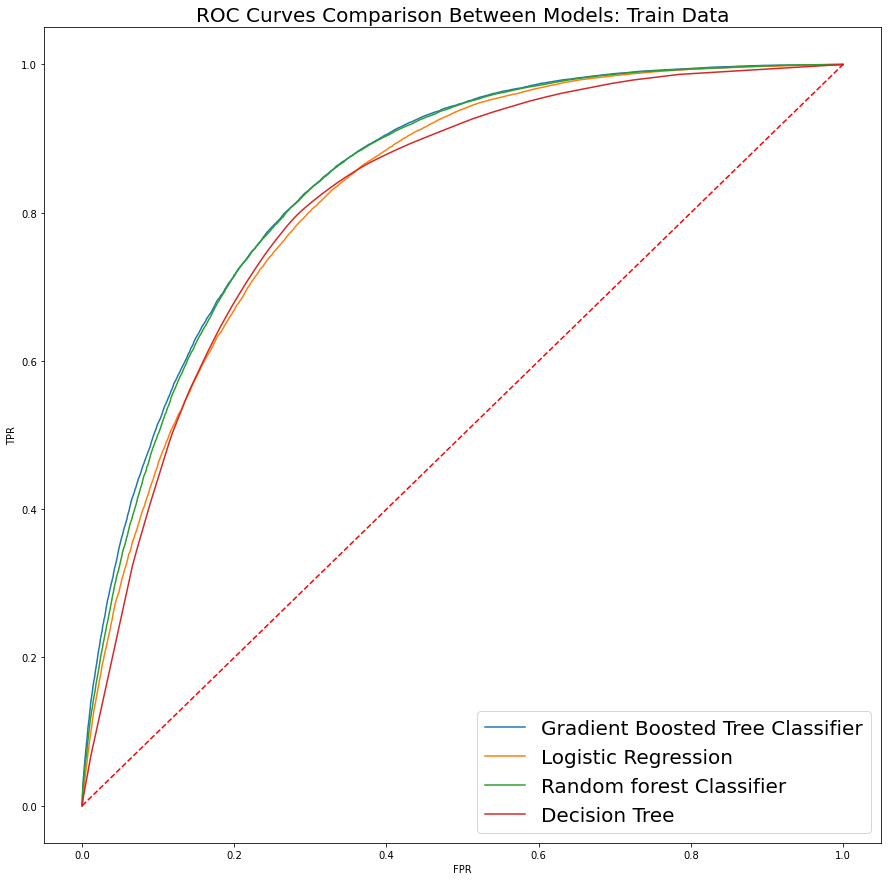

In [76]:
args = [
    [best_gbt_model, best_gbt_predictions_train, 'label', 'Gradient Boosted Tree Classifier', 'tree'],
    [best_lr_model, best_lr_preds_train, 'label', 'Logistic Regression', 'lr'],
    [best_rf_model, best_rf_predictions_train, 'label', 'Random forest Classifier', 'tree'],
    [best_dtree_model, best_dtree_predictions_train, 'label', 'Decision Tree', 'tree']
]
plot_roc(args, title=f'ROC Curves Comparison Between Models: Train Data')

##### ROC Curves of Test Data

Creating plot for: Gradient Boosted Tree Classifier


Creating plot for: Logistic Regression


Creating plot for: Random forest Classifier


Creating plot for: Decision Tree


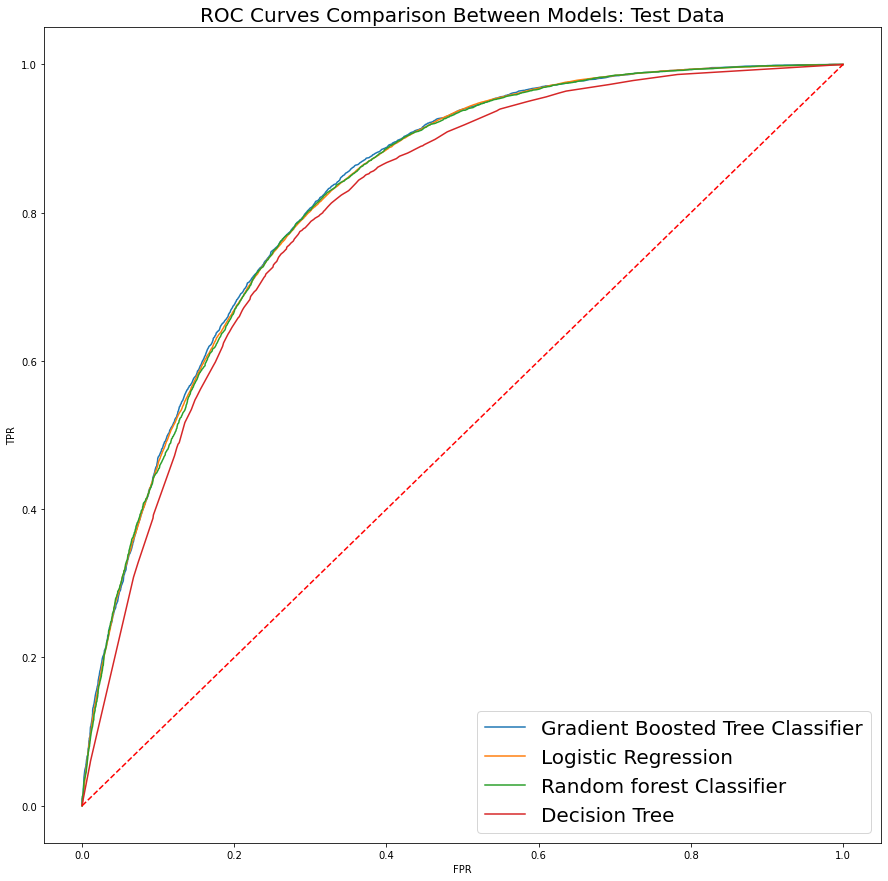

In [77]:
args = [
    [best_gbt_model, best_gbt_predictions_test, 'label', 'Gradient Boosted Tree Classifier', 'tree'],
    [best_lr_model, best_lr_preds_test, 'label', 'Logistic Regression', 'lr'],
    [best_rf_model, best_rf_predictions_test, 'label', 'Random forest Classifier', 'tree'],
    [best_dtree_model, best_dtree_predictions_test, 'label', 'Decision Tree', 'tree']
]
plot_roc(args, title=f'ROC Curves Comparison Between Models: Test Data')

## 6. Stop Spark Session: <a class="anchor" id="stop"></a>

In [78]:
spark.stop()